# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:

# import pandas as pd
# from utils.data_import import get_mkt_constitution, get_yf_data
# import os
# from datetime import datetime

# # Options
# FIRST_DATE  = "2015-01-01"
# LAST_DATE   = "2022-01-01"
# N_PROCESSES = 10
# MKT_INDEX   = "^SP100" # ^GSPC for SP500 or ^SP100 
# #MKT_INDEX   = "^GSPC"

# if not os.path.exists("data"):
#     os.mkdir("data")
    
# # get mkt constitutents    
# tickers = get_mkt_constitution(MKT_INDEX)

# today = datetime.today().strftime('%Y-%m-%d')
# print(f"Available Tickers for {MKT_INDEX} at {today}")
# print(tickers)
# print(" ")

# df_prices = get_yf_data(tickers, 
#                         FIRST_DATE,
#                         LAST_DATE,
#                         N_PROCESSES)

# print("\n\nOriginal price data")
# print(df_prices.head())

## Importing Dummy Data

In case the import with yfinance does not work, we read dummy data from csv files

In [ ]:

import pandas as pd
MKT_INDEX   = "^SP100"

tickers = pd.read_csv("data/constituents_SP100.csv")["Ticker"].tolist()
print(len(tickers), tickers[:5])

df_prices = pd.read_csv("data/prices_SP100_2015-01-01_2022-01-01.csv", parse_dates=['Date'])
# Normalize headers in case your editor added spaces/BOM
df_prices.columns = df_prices.columns.str.strip().str.replace('\ufeff','', regex=False)
df_prices = df_prices.set_index('Date')

# Quick sanity checks
assert {'ticker','Adj Close'} <= set(df_prices.columns), df_prices.columns.tolist()
assert (df_prices['Adj Close'].notna()).all()  # no gaps
assert (df_prices.loc[df_prices['ticker'].eq('^SP100')].shape[0] > 0)  # market series present


100 ['SP100_000', 'SP100_001', 'SP100_002', 'SP100_003', 'SP100_004']


## Cleaning and Splitting the Data

In [3]:
from sklearn.model_selection import train_test_split
import numpy  as np
import matplotlib.pyplot as plt
from utils.data_clean import clean_data

%load_ext autoreload
%autoreload 2

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.75   # defines the size of train dataset (in %)

df_ret, df_train, df_test  = clean_data(
    df_prices, 
    MKT_INDEX,
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

df_train.to_parquet("data/ret-data-cleaned-TRAIN.parquet")
df_test.to_parquet("data/ret-data-cleaned-TEST.parquet")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184527 entries, 2015-01-01 to 2021-12-31
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ticker     184527 non-null  object 
 1   Adj Close  184527 non-null  float64
dtypes: float64(1), object(1)
memory usage: 4.2+ MB
None
Size original: (184527, 2)
Size reduced: (184527, 2)


## Unconstrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   & w_i \geq 0 \\
\end{array}
$



$
\begin{array}{lll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [ ]:
import gurobipy as gp
from random import sample, seed

seed(20220209) # reproducibility

mkt_index = "^SP100"
n_assets = 20

# data from main notebook
r_it = pd.read_parquet("data/ret-data-cleaned-TRAIN.parquet")

r_mkt = r_it[mkt_index]

r_it = r_it.drop(mkt_index, axis = 1)

tickers = list(r_it.columns)

sampled_tickers = sample(tickers, n_assets)

r_it = r_it[sampled_tickers]

print(r_it.head())

ticker      SP100_079  SP100_002  SP100_006  SP100_064  SP100_055  SP100_047  \
Date                                                                           
2015-01-02  -0.004843  -0.002393  -0.005019   0.004037   0.000465   0.002547   
2015-01-05  -0.004629   0.003068   0.001998   0.002365  -0.002143   0.000507   
2015-01-06   0.002048   0.003316  -0.002014  -0.001199  -0.008744   0.007086   
2015-01-07   0.007274   0.002106   0.008187   0.007532   0.010223   0.005250   
2015-01-08  -0.006550   0.005762  -0.000604   0.003424   0.006477   0.008038   

ticker      SP100_080  SP100_043  SP100_052  SP100_057  SP100_073  SP100_083  \
Date                                                                           
2015-01-02   0.001900   0.002860  -0.003402  -0.010721   0.000490  -0.000093   
2015-01-05   0.014308   0.004691   0.004724   0.015756   0.009528   0.010147   
2015-01-06   0.006743   0.013316   0.005015   0.011296   0.000725   0.002130   
2015-01-07   0.007322   0.008469   0.01

# Setup opt problem and solve

In [5]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 

# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# CONSTRAINTS

# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.optimize()

w_hat  = [i.X for i in m.getVars()]

print(f"Solution:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2531600
WLS license 2531600 - registered to Gurobi Optimization
Solution:
SP100_079:	 3.62%
SP100_002:	 4.39%
SP100_006:	 4.47%
SP100_064:	 5.40%
SP100_055:	 7.55%
SP100_047:	 6.26%
SP100_080:	 6.00%
SP100_043:	 2.92%
SP100_052:	 4.81%
SP100_057:	 4.99%
SP100_073:	 4.43%
SP100_083:	 5.36%
SP100_090:	 5.19%
SP100_036:	 5.14%
SP100_062:	 4.70%
SP100_010:	 5.88%
SP100_016:	 4.46%
SP100_045:	 5.15%
SP100_040:	 3.60%
SP100_013:	 5.70%

checking constraints:
sum(w) = 0.9999999999999998


Index(['SP100_000', 'SP100_001', 'SP100_002', 'SP100_003', 'SP100_004',
       'SP100_005', 'SP100_006', 'SP100_007', 'SP100_008', 'SP100_009',
       ...
       'SP100_091', 'SP100_092', 'SP100_093', 'SP100_094', 'SP100_095',
       'SP100_096', 'SP100_097', 'SP100_098', 'SP100_099', '^SP100'],
      dtype='object', name='ticker', length=101)
['SP100_079', 'SP100_002', 'SP100_006', 'SP100_064', 'SP100_055', 'SP100_047', 'SP100_080', 'SP100_043', 'SP100_052', 'SP100_057', 'SP100_073', 'SP100_083', 'SP100_090', 'SP100_036', 'SP100_062', 'SP100_010', 'SP100_016', 'SP100_045', 'SP100_040', 'SP100_013']


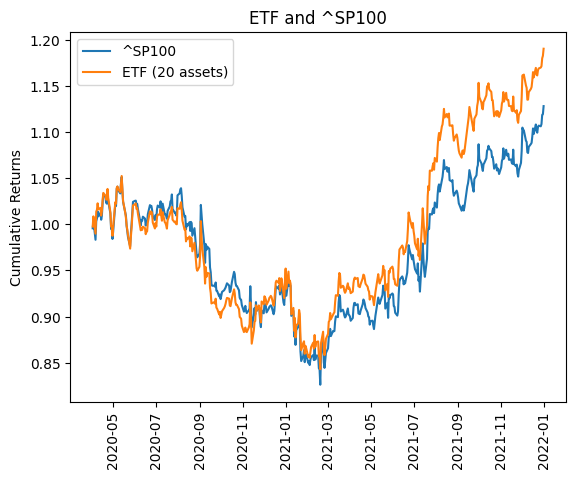

In [6]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = pd.read_parquet("data/ret-data-cleaned-TEST.parquet")

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()

## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [7]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 

max_assets = 10

# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 0.2,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# [NEW] z_i: the i_th stock gets a binary z_i
z = pd.Series(m.addVars(sampled_tickers,
                        vtype = gp.GRB.BINARY),
                index=sampled_tickers)

# CONSTRAINTS

# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')

# [NEW]  w_i <= z_i: restrictions of values of w_i so take it chose particular tickers
for i_ticker in sampled_tickers:
    m.addConstr(w[i_ticker] <= z[i_ticker], 
                f'dummy_restriction_{i_ticker}')

# [NEW] sum(z_i) <= max_assets: number of assets constraint
m.addConstr(z.sum() <= max_assets, 'max_assets_restriction')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.setParam('TimeLimit', 60*5) # in secs
#m.setParam('MIPGap', 0.05) # in secs
m.optimize()

params = [i.X for i in m.getVars()]

n_assets = len(sampled_tickers)
w_hat = params[0:n_assets]
z_hat = params[n_assets:]
MIPGap = m.getAttr('MIPGap')
status = m.getAttr("Status")

print(f"Solution for w:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")
print(f"sum(z) = {np.sum(z_hat)}")
print(f"w <= z = {w_hat <= z_hat}")
print(f"MIPGap={MIPGap}")
print(f"Status={status}")

Solution for w:
SP100_079:	 0.00%
SP100_002:	 10.82%
SP100_006:	 0.00%
SP100_064:	 9.38%
SP100_055:	 11.26%
SP100_047:	 10.40%
SP100_080:	 9.88%
SP100_043:	 0.00%
SP100_052:	 0.00%
SP100_057:	 8.27%
SP100_073:	 0.00%
SP100_083:	 10.71%
SP100_090:	 10.58%
SP100_036:	 9.92%
SP100_062:	 0.00%
SP100_010:	 0.00%
SP100_016:	 0.00%
SP100_045:	 8.77%
SP100_040:	 0.00%
SP100_013:	 0.00%

checking constraints:
sum(w) = 0.9999999999999998
sum(z) = 10.0
w <= z = True
MIPGap=2.1150932386377818e-05
Status=2


Index(['SP100_000', 'SP100_001', 'SP100_002', 'SP100_003', 'SP100_004',
       'SP100_005', 'SP100_006', 'SP100_007', 'SP100_008', 'SP100_009',
       ...
       'SP100_091', 'SP100_092', 'SP100_093', 'SP100_094', 'SP100_095',
       'SP100_096', 'SP100_097', 'SP100_098', 'SP100_099', '^SP100'],
      dtype='object', name='ticker', length=101)
['SP100_079', 'SP100_002', 'SP100_006', 'SP100_064', 'SP100_055', 'SP100_047', 'SP100_080', 'SP100_043', 'SP100_052', 'SP100_057', 'SP100_073', 'SP100_083', 'SP100_090', 'SP100_036', 'SP100_062', 'SP100_010', 'SP100_016', 'SP100_045', 'SP100_040', 'SP100_013']


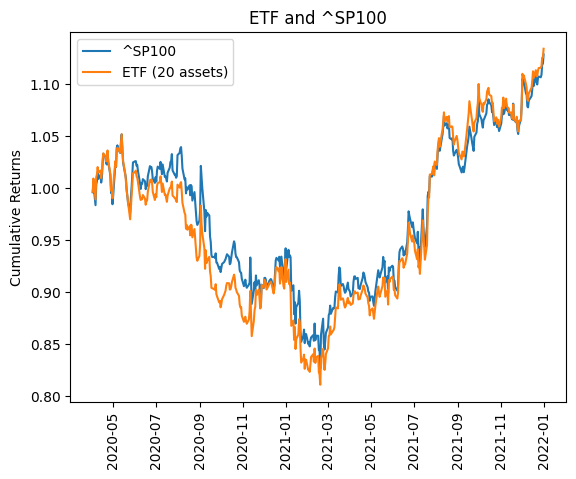

In [8]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = pd.read_parquet("data/ret-data-cleaned-TEST.parquet")

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()